In [1]:
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [35]:
#load trained model
autoencoder = load_model('0423.keras')

height, width, channels = 372, 1244, 1  #input image format
input_img = Input(shape=(height, width, channels))
#print(input_img)

def preprocess_image(image):
    #resize image so they're same format
    image = tf.image.resize(image, (height, width), method='lanczos5')
    return image

datagen = ImageDataGenerator(
    #normalize image so values are 0>= and <=1
    rescale=1./255,
    preprocessing_function=preprocess_image
)
validate_normal = datagen.flow_from_directory(
    'thesis/validateNormal',  #path to dataset
    target_size=(height, width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)
validate_anomalous = datagen.flow_from_directory(
    'thesis/validateAnomalous',  #path to dataset
    target_size=(height, width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


In [7]:
normal_reconstructions = autoencoder.predict(validate_normal, steps=len(validate_normal))
anomalous_reconstructions = autoencoder.predict(validate_anomalous, steps=len(validate_anomalous))

ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 372, 1244, 1), found shape=(15, 376, 1248)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


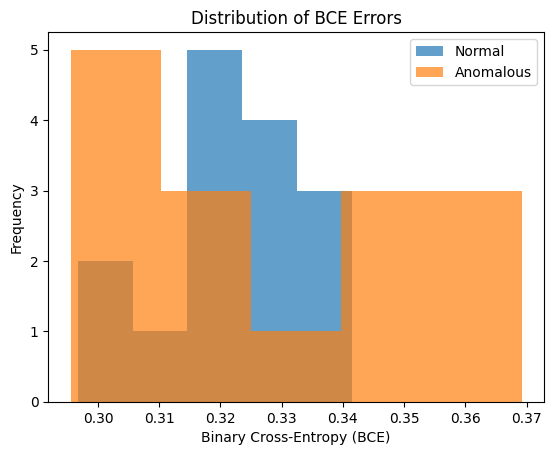

In [4]:
#function to calculate BCE
def bce_loss(original, reconstruction):
    epsilon = 1e-10
    original = np.clip(original, epsilon, 1. - epsilon)
    reconstruction = np.clip(reconstruction, epsilon, 1. - epsilon)
    bce = -np.mean(original * np.log(reconstruction) + (1. - original) * np.log(1. - reconstruction))
    return bce

def calculate_bce_values(model, test_generator):

    # Initialize BCE values array
    bce_values = []

    # Get predictions for the test images
    predicted_images = model.predict(test_generator, steps=len(test_generator))

    # Reset generator for consistent image fetching
    test_generator.reset()
    count = 0

    for original_batch, _ in test_generator:
        for j in range(original_batch.shape[0]):
            if count >= 15:
                break

            original_img = original_batch[j]
            predicted_img = predicted_images[count]

            # Calculate BCE and store it
            loss = bce_loss(original_img, predicted_img)
            bce_values.append(loss)

            count += 1
        if count >= 15:
            break

    return bce_values

bce_normal = calculate_bce_values(autoencoder, validate_normal)
bce_anomalous = calculate_bce_values(autoencoder,validate_anomalous)
# Now plot
plt.hist(bce_normal, bins=5, alpha=0.7, label='Normal')
plt.hist(bce_anomalous, bins=5, alpha=0.7, label='Anomalous')
plt.xlabel('Binary Cross-Entropy (BCE)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of BCE Errors')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


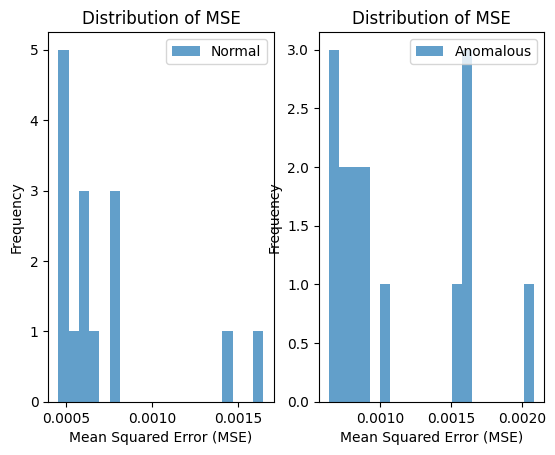

In [36]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean(np.square(original - reconstruction))

def calculate_mse_values(model, test_generator):

    # Initialize BCE values array
    bce_values = []

    # Get predictions for the test images
    predicted_images = model.predict(test_generator, steps=len(test_generator))

    # Reset generator for consistent image fetching
    test_generator.reset()
    count = 0

    for original_batch, _ in test_generator:
        for j in range(original_batch.shape[0]):
            if count >= 15:
                break

            original_img = original_batch[j]
            predicted_img = predicted_images[count]

            # Calculate BCE and store it
            loss = mse_loss(original_img, predicted_img)
            bce_values.append(loss)

            count += 1
        if count >= 15:
            break

    return bce_values

mse_normal = calculate_mse_values(autoencoder, validate_normal)
mse_anomalous = calculate_mse_values(autoencoder,validate_anomalous)

# First histogram for Normal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(mse_normal, bins=20, alpha=0.7, label='Normal')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE')
plt.legend()

# Second histogram for Anomalous
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(mse_anomalous, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE')
plt.legend()


plt.show()


In [5]:
print(mse_anomalous)
print(mse_normal)

[0.0044153905, 0.0010753114, 0.002933873, 0.00080950075, 0.0008575118, 0.0034981128, 0.0010280458, 0.0008033748, 0.001966564, 0.0043371646, 0.00060933176, 0.0008826702, 0.0009407333, 0.00077939255, 0.0009860393]
[0.0006920122, 0.00064920454, 0.00061621604, 0.00062199205, 0.00069465477, 0.0039590597, 0.0009054967, 0.0008129923, 0.0006606337, 0.00067816325, 0.0005931485, 0.0005700597, 0.0012415702, 0.0016305657, 0.0007461544]


In [37]:
print(sum(mse_anomalous))
print(sum(mse_normal))
print(sum(mse_anomalous)-sum(mse_normal))

0.01644296367885545
0.010906164941843599
0.00553679873701185


In [38]:
# Compute the mean and standard deviation of the BCE values
mean_bce_normal = np.mean(mse_normal)
std_bce_normal = np.std(mse_normal)

# Calculate the threshold as mean + 2 * standard deviation
threshold = mean_bce_normal + 1 * std_bce_normal

print(f"Calculated Threshold: {threshold}")


Calculated Threshold: 0.0010622616682667285
